## Scenario 1: building a model trained on stream gauges

### a) Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.layers import Flatten
from sklearn.model_selection import train_test_split
import h5py
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import r2_score, mean_absolute_error, median_absolute_error, mean_squared_error
import random as rn
from scikeras.wrappers import KerasRegressor
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import shap
import warnings



# Set random seeds for reproducibility
np.random.seed(1)
rn.seed(1)
tf.random.set_seed(1)


### b) Reading the stream gauges data for hurricane Ida

In [2]:
# Read the CSV file into a pandas DataFrame
df_all = pd.read_csv('Ida.csv', header=0)
df = df_all[df_all['Type'] == 'Stream']

df

,FID,Shape,site_no,latitude,longitude,Uncertainty,Type,Flood,Altitude,Rain,...,Soil moisture,Slope,Curvature,Flow accumulation,TWI,Distance to river,Distance to storm track,Distance to sea,Tide,Mean gauge height
258,14,Point,1397420,40.501944,-74.742500,0.0,Stream,20.410549,20.0544,249.5,...,0.428718,0.208936,509461000,0,-108.597000,0.000327,0.435586,0.471549,1.283260,6.689451
259,15,Point,1401000,40.333056,-74.681944,0.0,Stream,14.947292,19.0872,179.5,...,0.411208,1.261950,-1931920000,710,2.094690,0.000047,0.256518,0.437684,1.380100,3.152708
260,16,Point,1401750,40.440000,-74.617500,0.0,Stream,17.853021,10.0583,226.8,...,0.430111,14.066700,-21783000000,2,0.048925,0.000412,0.341303,0.349136,1.232540,5.366979
261,17,Point,1405400,40.389444,-74.390556,0.0,Stream,5.468542,4.8600,168.5,...,0.430111,1.069650,0,12,1.361210,0.000502,0.229589,0.148389,1.107650,10.061458
262,18,Point,1406050,40.415000,-74.348889,0.0,Stream,1.502917,2.0600,179.3,...,0.388148,1.129560,0,88,2.114610,0.001299,0.242540,0.099543,1.094590,6.927083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,352,Point,1374505,41.394583,-73.607472,0.0,Stream,2.502708,101.3900,142.8,...,0.279366,12.305600,-1685520000,4,-5.195090,0.000179,0.979721,0.370593,0.935456,3.757292
353,353,Point,1374531,41.373389,-73.639583,0.0,Stream,5.177292,84.5413,142.9,...,0.352202,1.420260,-1222070000,61,0.623553,0.000442,0.967796,0.360568,0.953227,2.472708
354,354,Point,1374781,41.327361,-73.591472,0.0,Stream,2.503854,104.1990,155.6,...,0.258539,5.531940,203999000,20,-3.207680,0.000335,0.910662,0.303099,0.978951,2.266146
355,355,Point,1374559,41.470472,-73.759583,0.0,Stream,2.766563,183.4710,129.8,...,0.381326,14.157900,3799270000,69,-0.087799,0.000407,1.093210,0.481995,0.902405,1.503437


### c) Adding new features that consider interactions between existing features, identified through the forward feature selection method.

In [3]:
# List of interaction terms
interaction_terms = [
('Altitude','Rain' ),
('Altitude','Slope' ),
('Altitude','Curvature' ),
('Altitude','Tide' ),
('Altitude','Distance to storm track' ),
('Rain','Soil moisture' ),
('Rain','Curvature' ),
('Rain','Flow accumulation' ),
('Rain','Distance to storm track' ),
('Rain','Mean gauge height' ),
('HAND','Wind speed' ),
('HAND','Slope' ),
('HAND','TWI' ),
('HAND','Tide' ),
('HAND','Distance to storm track' ),
('HAND','Distance to sea' ),
('HAND','Mean gauge height' ),
('Wind speed','Soil moisture' ),
('Wind speed','TWI' ),
('Wind speed','Tide' ),
('Soil moisture','TWI' ),
('Soil moisture','Tide' ),
('Soil moisture','Distance to storm track' ),
('Soil moisture','Distance to sea' ),
('Soil moisture','Mean gauge height' ),
('Slope','Curvature' ),
('Slope','Tide' ),
('Slope','Distance to sea' ),
('Slope','Mean gauge height' ),
('Curvature','Tide' ),
('Flow accumulation','TWI' ),
('Flow accumulation','Tide' ),
('Flow accumulation','Mean gauge height' ),
('TWI','Tide' ),
('TWI','Distance to storm track' ),
('TWI','Distance to sea' ),
('Tide','Distance to sea' ),
('Tide','Mean gauge height' ),
('Distance to storm track','Distance to sea' ),
('Distance to storm track','Mean gauge height' ),
]


# Ensure you are working on a copy of the DataFrame
df = df.copy()

# Loop through the interaction terms and create each interaction column using .loc
for term1, term2 in interaction_terms:
    column_name = f'{term1}:{term2}'
    df.loc[:, column_name] = df[term1] * df[term2]

# Check the updated columns
df.columns

Index(['FID', 'Shape', 'site_no', 'latitude', 'longitude', 'Uncertainty',
       'Type', 'Flood', 'Altitude', 'Rain', 'HAND', 'Storm surge',
       'Wind speed', 'Soil moisture', 'Slope', 'Curvature',
       'Flow accumulation', 'TWI', 'Distance to river',
       'Distance to storm track', 'Distance to sea', 'Tide',
       'Mean gauge height', 'Altitude:Rain', 'Altitude:Slope',
       'Altitude:Curvature', 'Altitude:Tide',
       'Altitude:Distance to storm track', 'Rain:Soil moisture',
       'Rain:Curvature', 'Rain:Flow accumulation',
       'Rain:Distance to storm track', 'Rain:Mean gauge height',
       'HAND:Wind speed', 'HAND:Slope', 'HAND:TWI', 'HAND:Tide',
       'HAND:Distance to storm track', 'HAND:Distance to sea',
       'HAND:Mean gauge height', 'Wind speed:Soil moisture', 'Wind speed:TWI',
       'Wind speed:Tide', 'Soil moisture:TWI', 'Soil moisture:Tide',
       'Soil moisture:Distance to storm track',
       'Soil moisture:Distance to sea', 'Soil moisture:Mean gauge he

### d) Spliting and Scaling data

In [4]:
features= [
    'Altitude', 
    'Rain', 
    'Wind speed', 
    'Soil moisture', 
    'Slope', 
    'Curvature', 
    'Flow accumulation',  
    'Tide', 
    'Distance to storm track', 
    'Distance to sea', 
    'Altitude:Slope', 
    'Altitude:Curvature', 
    'Altitude:Tide', 
    'Rain:Curvature', 
    'Rain:Flow accumulation', 
    'Rain:Mean gauge height',  
    'Soil moisture:TWI', 
    'Soil moisture:Tide', 
    'Soil moisture:Distance to storm track', 
    'Soil moisture:Distance to sea', 
    'Soil moisture:Mean gauge height', 
    'Slope:Curvature', 
    'Slope:Tide', 
    'Slope:Distance to sea', 
    'Curvature:Tide', 
    'Flow accumulation:TWI', 
    'Flow accumulation:Tide', 
    'Flow accumulation:Mean gauge height', 
    'TWI:Tide', 
    'TWI:Distance to sea', 
    'Distance to storm track:Mean gauge height'
]
x = df[features].copy()


y = df['Flood']* 0.3048  #ft to m
x.shape

(99, 31)

In [5]:
# Split data into training and testing sets
Xtrain, Xtest, Ytrain, Ytest = train_test_split(x.values, y.values, test_size=0.2, random_state=64)


# Standardize the numerical features
scaler = StandardScaler()
Xtrain_scaled = scaler.fit_transform(Xtrain)
Xtest_scaled = scaler.fit_transform(Xtest)

### f) Creating a model 

In [38]:
def create_model(num_layers, num_units, regularization_rate, optimizer, activations):
    # Assuming 'features' is defined globally or this part of the code is adjusted to include it
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(len(features),)))
    
    # Dynamically add layers
    for _ in range(int(num_layers)):
        model.add(tf.keras.layers.Dense(int(num_units), activation=activations,
                                        kernel_initializer=tf.keras.initializers.he_normal(seed=1),
                                        bias_initializer='zeros',
                                        kernel_regularizer=tf.keras.regularizers.l2(regularization_rate)))

    model.add(tf.keras.layers.Dense(1, kernel_initializer='he_normal', bias_initializer='zeros'))
    
    model.compile(optimizer=optimizer,
                  loss='mean_absolute_error',
                  metrics=['mean_absolute_error'])
    
    return model


# Create and train the model with the best hyperparameters
model = create_model(
    num_layers= 3,
    num_units= 64,
    regularization_rate= 0.06,
    optimizer= 'sgd',
    activations= 'elu',
)


# Define a custom callback function
class CustomEarlyStopping(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs['val_loss'] < .6 and logs['loss']< .6:
            self.model.stop_training = True

# Create an instance of the custom callback
custom_early_stopping = CustomEarlyStopping()

# Define model checkpointing
model_checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True)

# Train the model and generate the training history
history = model.fit(
                    Xtrain_scaled, 
                    Ytrain, 
                    validation_data=(Xtest_scaled, Ytest), 
                    batch_size=16, 
                    epochs=2000, 
                    callbacks=[custom_early_stopping, model_checkpoint]
                   )


Epoch 1/2000
5/5 [==============================] - 1s 59ms/step - loss: 25.1534 - mean_absolute_error: 2.0600 - val_loss: 24.8504 - val_mean_absolute_error: 1.9297
Epoch 2/2000
5/5 [==============================] - 0s 19ms/step - loss: 24.2096 - mean_absolute_error: 1.3984 - val_loss: 24.3289 - val_mean_absolute_error: 1.6826
Epoch 3/2000
5/5 [==============================] - 0s 19ms/step - loss: 23.7799 - mean_absolute_error: 1.2415 - val_loss: 23.8253 - val_mean_absolute_error: 1.4528
Epoch 4/2000
5/5 [==============================] - 0s 18ms/step - loss: 23.3604 - mean_absolute_error: 1.0942 - val_loss: 23.3728 - val_mean_absolute_error: 1.2696
Epoch 5/2000
5/5 [==============================] - 0s 18ms/step - loss: 23.0044 - mean_absolute_error: 1.0035 - val_loss: 22.9531 - val_mean_absolute_error: 1.1120
Epoch 6/2000
5/5 [==============================] - 0s 18ms/step - loss: 22.6045 - mean_absolute_error: 0.8664 - val_loss: 22.7825 - val_mean_absolute_error: 1.2038
Epoch 7/20

Epoch 100/2000
5/5 [==============================] - 0s 16ms/step - loss: 7.6396 - mean_absolute_error: 0.4363 - val_loss: 8.0797 - val_mean_absolute_error: 0.9281
Epoch 101/2000
5/5 [==============================] - 0s 19ms/step - loss: 7.5909 - mean_absolute_error: 0.4717 - val_loss: 8.0134 - val_mean_absolute_error: 0.9401
Epoch 102/2000
5/5 [==============================] - 0s 28ms/step - loss: 7.4971 - mean_absolute_error: 0.4582 - val_loss: 7.8859 - val_mean_absolute_error: 0.8977
Epoch 103/2000
5/5 [==============================] - 0s 19ms/step - loss: 7.4197 - mean_absolute_error: 0.4624 - val_loss: 7.8568 - val_mean_absolute_error: 0.9490
Epoch 104/2000
5/5 [==============================] - 0s 19ms/step - loss: 7.3621 - mean_absolute_error: 0.4837 - val_loss: 7.7334 - val_mean_absolute_error: 0.9040
Epoch 105/2000
5/5 [==============================] - 0s 23ms/step - loss: 7.2582 - mean_absolute_error: 0.4604 - val_loss: 7.7120 - val_mean_absolute_error: 0.9614
Epoch 106/

Epoch 150/2000
5/5 [==============================] - 0s 20ms/step - loss: 4.5530 - mean_absolute_error: 0.4771 - val_loss: 4.8986 - val_mean_absolute_error: 0.8496
Epoch 151/2000
5/5 [==============================] - 0s 15ms/step - loss: 4.5004 - mean_absolute_error: 0.4699 - val_loss: 4.8875 - val_mean_absolute_error: 0.8830
Epoch 152/2000
5/5 [==============================] - 0s 16ms/step - loss: 4.4783 - mean_absolute_error: 0.4917 - val_loss: 4.8363 - val_mean_absolute_error: 0.8791
Epoch 153/2000
5/5 [==============================] - 0s 20ms/step - loss: 4.4206 - mean_absolute_error: 0.4799 - val_loss: 4.7629 - val_mean_absolute_error: 0.8477
Epoch 154/2000
5/5 [==============================] - 0s 15ms/step - loss: 4.3747 - mean_absolute_error: 0.4779 - val_loss: 4.7330 - val_mean_absolute_error: 0.8623
Epoch 155/2000
5/5 [==============================] - 0s 16ms/step - loss: 4.3309 - mean_absolute_error: 0.4768 - val_loss: 4.6574 - val_mean_absolute_error: 0.8306
Epoch 156/

Epoch 200/2000
5/5 [==============================] - 0s 16ms/step - loss: 2.8356 - mean_absolute_error: 0.4796 - val_loss: 3.1622 - val_mean_absolute_error: 0.8215
Epoch 201/2000
5/5 [==============================] - 0s 19ms/step - loss: 2.8104 - mean_absolute_error: 0.4808 - val_loss: 3.1484 - val_mean_absolute_error: 0.8356
Epoch 202/2000
5/5 [==============================] - 0s 24ms/step - loss: 2.7908 - mean_absolute_error: 0.4872 - val_loss: 3.1194 - val_mean_absolute_error: 0.8311
Epoch 203/2000
5/5 [==============================] - 0s 23ms/step - loss: 2.7644 - mean_absolute_error: 0.4854 - val_loss: 3.0985 - val_mean_absolute_error: 0.8316
Epoch 204/2000
5/5 [==============================] - 0s 24ms/step - loss: 2.7495 - mean_absolute_error: 0.4924 - val_loss: 3.0788 - val_mean_absolute_error: 0.8385
Epoch 205/2000
5/5 [==============================] - 0s 24ms/step - loss: 2.7267 - mean_absolute_error: 0.4951 - val_loss: 3.0406 - val_mean_absolute_error: 0.8219
Epoch 206/

Epoch 250/2000
5/5 [==============================] - 0s 11ms/step - loss: 1.9181 - mean_absolute_error: 0.5149 - val_loss: 2.2224 - val_mean_absolute_error: 0.8276
Epoch 251/2000
5/5 [==============================] - 0s 18ms/step - loss: 1.8942 - mean_absolute_error: 0.5054 - val_loss: 2.1860 - val_mean_absolute_error: 0.8063
Epoch 252/2000
5/5 [==============================] - 0s 20ms/step - loss: 1.8769 - mean_absolute_error: 0.5028 - val_loss: 2.1535 - val_mean_absolute_error: 0.7884
Epoch 253/2000
5/5 [==============================] - 0s 10ms/step - loss: 1.8709 - mean_absolute_error: 0.5106 - val_loss: 2.1680 - val_mean_absolute_error: 0.8153
Epoch 254/2000
5/5 [==============================] - 0s 18ms/step - loss: 1.8435 - mean_absolute_error: 0.4959 - val_loss: 2.1337 - val_mean_absolute_error: 0.7938
Epoch 255/2000
5/5 [==============================] - 0s 12ms/step - loss: 1.8424 - mean_absolute_error: 0.5088 - val_loss: 2.1397 - val_mean_absolute_error: 0.8138
Epoch 256/

Epoch 300/2000
5/5 [==============================] - 0s 11ms/step - loss: 1.3847 - mean_absolute_error: 0.5141 - val_loss: 1.6723 - val_mean_absolute_error: 0.8064
Epoch 301/2000
5/5 [==============================] - 0s 18ms/step - loss: 1.3735 - mean_absolute_error: 0.5114 - val_loss: 1.6342 - val_mean_absolute_error: 0.7752
Epoch 302/2000
5/5 [==============================] - 0s 11ms/step - loss: 1.3809 - mean_absolute_error: 0.5258 - val_loss: 1.6547 - val_mean_absolute_error: 0.8039
Epoch 303/2000
5/5 [==============================] - 0s 18ms/step - loss: 1.3616 - mean_absolute_error: 0.5143 - val_loss: 1.6267 - val_mean_absolute_error: 0.7847
Epoch 304/2000
5/5 [==============================] - 0s 15ms/step - loss: 1.3557 - mean_absolute_error: 0.5160 - val_loss: 1.6112 - val_mean_absolute_error: 0.7752
Epoch 305/2000
5/5 [==============================] - 0s 11ms/step - loss: 1.3571 - mean_absolute_error: 0.5244 - val_loss: 1.6203 - val_mean_absolute_error: 0.7923
Epoch 306/

Epoch 350/2000
5/5 [==============================] - 0s 12ms/step - loss: 1.0847 - mean_absolute_error: 0.5107 - val_loss: 1.3782 - val_mean_absolute_error: 0.8078
Epoch 351/2000
5/5 [==============================] - 0s 18ms/step - loss: 1.0738 - mean_absolute_error: 0.5045 - val_loss: 1.3443 - val_mean_absolute_error: 0.7757
Epoch 352/2000
5/5 [==============================] - 0s 13ms/step - loss: 1.0799 - mean_absolute_error: 0.5149 - val_loss: 1.3582 - val_mean_absolute_error: 0.7957
Epoch 353/2000
5/5 [==============================] - 0s 13ms/step - loss: 1.0787 - mean_absolute_error: 0.5174 - val_loss: 1.3401 - val_mean_absolute_error: 0.7823
Epoch 354/2000
5/5 [==============================] - 0s 12ms/step - loss: 1.0693 - mean_absolute_error: 0.5125 - val_loss: 1.3508 - val_mean_absolute_error: 0.7960
Epoch 355/2000
5/5 [==============================] - 0s 16ms/step - loss: 1.0699 - mean_absolute_error: 0.5160 - val_loss: 1.3242 - val_mean_absolute_error: 0.7727
Epoch 356/

Epoch 400/2000
5/5 [==============================] - 0s 45ms/step - loss: 0.9167 - mean_absolute_error: 0.5137 - val_loss: 1.1756 - val_mean_absolute_error: 0.7728
Epoch 401/2000
5/5 [==============================] - 0s 14ms/step - loss: 0.9102 - mean_absolute_error: 0.5097 - val_loss: 1.1973 - val_mean_absolute_error: 0.7989
Epoch 402/2000
5/5 [==============================] - 0s 30ms/step - loss: 0.8948 - mean_absolute_error: 0.4971 - val_loss: 1.1651 - val_mean_absolute_error: 0.7673
Epoch 403/2000
5/5 [==============================] - 0s 12ms/step - loss: 0.9120 - mean_absolute_error: 0.5159 - val_loss: 1.1804 - val_mean_absolute_error: 0.7859
Epoch 404/2000
5/5 [==============================] - 0s 21ms/step - loss: 0.8981 - mean_absolute_error: 0.5051 - val_loss: 1.1621 - val_mean_absolute_error: 0.7696
Epoch 405/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.9070 - mean_absolute_error: 0.5156 - val_loss: 1.1780 - val_mean_absolute_error: 0.7877
Epoch 406/

Epoch 450/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.8047 - mean_absolute_error: 0.5006 - val_loss: 1.0936 - val_mean_absolute_error: 0.7893
Epoch 451/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.8225 - mean_absolute_error: 0.5181 - val_loss: 1.1262 - val_mean_absolute_error: 0.8260
Epoch 452/2000
5/5 [==============================] - 0s 14ms/step - loss: 0.8186 - mean_absolute_error: 0.5173 - val_loss: 1.0853 - val_mean_absolute_error: 0.7848
Epoch 453/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.8040 - mean_absolute_error: 0.5036 - val_loss: 1.0817 - val_mean_absolute_error: 0.7798
Epoch 454/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.8100 - mean_absolute_error: 0.5108 - val_loss: 1.0881 - val_mean_absolute_error: 0.7903
Epoch 455/2000
5/5 [==============================] - 0s 12ms/step - loss: 0.8063 - mean_absolute_error: 0.5086 - val_loss: 1.0858 - val_mean_absolute_error: 0.7880
Epoch 456/2

Epoch 500/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.7644 - mean_absolute_error: 0.5180 - val_loss: 1.0292 - val_mean_absolute_error: 0.7826
Epoch 501/2000
5/5 [==============================] - 0s 19ms/step - loss: 0.7482 - mean_absolute_error: 0.5025 - val_loss: 1.0094 - val_mean_absolute_error: 0.7647
Epoch 502/2000
5/5 [==============================] - 0s 12ms/step - loss: 0.7598 - mean_absolute_error: 0.5155 - val_loss: 1.0148 - val_mean_absolute_error: 0.7686
Epoch 503/2000
5/5 [==============================] - 0s 13ms/step - loss: 0.7413 - mean_absolute_error: 0.4964 - val_loss: 1.0238 - val_mean_absolute_error: 0.7798
Epoch 504/2000
5/5 [==============================] - 0s 15ms/step - loss: 0.7649 - mean_absolute_error: 0.5205 - val_loss: 1.0296 - val_mean_absolute_error: 0.7858
Epoch 505/2000
5/5 [==============================] - 0s 13ms/step - loss: 0.7423 - mean_absolute_error: 0.4986 - val_loss: 1.0167 - val_mean_absolute_error: 0.7738
Epoch 506/

Epoch 550/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.7173 - mean_absolute_error: 0.5049 - val_loss: 0.9984 - val_mean_absolute_error: 0.7866
Epoch 551/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.7048 - mean_absolute_error: 0.4931 - val_loss: 0.9919 - val_mean_absolute_error: 0.7797
Epoch 552/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.7155 - mean_absolute_error: 0.5039 - val_loss: 0.9823 - val_mean_absolute_error: 0.7717
Epoch 553/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.7293 - mean_absolute_error: 0.5181 - val_loss: 0.9822 - val_mean_absolute_error: 0.7708
Epoch 554/2000
5/5 [==============================] - 0s 12ms/step - loss: 0.7161 - mean_absolute_error: 0.5058 - val_loss: 0.9908 - val_mean_absolute_error: 0.7811
Epoch 555/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.7047 - mean_absolute_error: 0.4946 - val_loss: 0.9869 - val_mean_absolute_error: 0.7759
Epoch 556/

Epoch 600/2000
5/5 [==============================] - 0s 14ms/step - loss: 0.6896 - mean_absolute_error: 0.4959 - val_loss: 0.9865 - val_mean_absolute_error: 0.7926
Epoch 601/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.6829 - mean_absolute_error: 0.4886 - val_loss: 0.9661 - val_mean_absolute_error: 0.7725
Epoch 602/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.6915 - mean_absolute_error: 0.4974 - val_loss: 0.9726 - val_mean_absolute_error: 0.7787
Epoch 603/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.6885 - mean_absolute_error: 0.4958 - val_loss: 0.9611 - val_mean_absolute_error: 0.7682
Epoch 604/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.6824 - mean_absolute_error: 0.4897 - val_loss: 0.9649 - val_mean_absolute_error: 0.7724
Epoch 605/2000
5/5 [==============================] - 0s 12ms/step - loss: 0.6895 - mean_absolute_error: 0.4974 - val_loss: 0.9599 - val_mean_absolute_error: 0.7678
Epoch 606/

Epoch 650/2000
5/5 [==============================] - 0s 12ms/step - loss: 0.6842 - mean_absolute_error: 0.5021 - val_loss: 0.9316 - val_mean_absolute_error: 0.7483
Epoch 651/2000
5/5 [==============================] - 0s 12ms/step - loss: 0.6774 - mean_absolute_error: 0.4943 - val_loss: 0.9742 - val_mean_absolute_error: 0.7929
Epoch 652/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.6685 - mean_absolute_error: 0.4866 - val_loss: 0.9409 - val_mean_absolute_error: 0.7575
Epoch 653/2000
5/5 [==============================] - 0s 24ms/step - loss: 0.6841 - mean_absolute_error: 0.5015 - val_loss: 0.9302 - val_mean_absolute_error: 0.7479
Epoch 654/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.6724 - mean_absolute_error: 0.4916 - val_loss: 0.9446 - val_mean_absolute_error: 0.7642
Epoch 655/2000
5/5 [==============================] - 0s 21ms/step - loss: 0.6722 - mean_absolute_error: 0.4918 - val_loss: 0.9212 - val_mean_absolute_error: 0.7411
Epoch 656/

Epoch 700/2000
5/5 [==============================] - 0s 12ms/step - loss: 0.6550 - mean_absolute_error: 0.4804 - val_loss: 0.9368 - val_mean_absolute_error: 0.7639
Epoch 701/2000
5/5 [==============================] - 0s 14ms/step - loss: 0.6590 - mean_absolute_error: 0.4855 - val_loss: 0.9403 - val_mean_absolute_error: 0.7643
Epoch 702/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.6780 - mean_absolute_error: 0.5028 - val_loss: 0.9373 - val_mean_absolute_error: 0.7625
Epoch 703/2000
5/5 [==============================] - 0s 12ms/step - loss: 0.6656 - mean_absolute_error: 0.4904 - val_loss: 0.9492 - val_mean_absolute_error: 0.7740
Epoch 704/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.6641 - mean_absolute_error: 0.4887 - val_loss: 0.9219 - val_mean_absolute_error: 0.7469
Epoch 705/2000
5/5 [==============================] - 0s 9ms/step - loss: 0.6728 - mean_absolute_error: 0.4976 - val_loss: 0.9247 - val_mean_absolute_error: 0.7498
Epoch 706/2

Epoch 750/2000
5/5 [==============================] - 0s 13ms/step - loss: 0.6644 - mean_absolute_error: 0.4939 - val_loss: 0.9283 - val_mean_absolute_error: 0.7591
Epoch 751/2000
5/5 [==============================] - 0s 14ms/step - loss: 0.6666 - mean_absolute_error: 0.4965 - val_loss: 0.9198 - val_mean_absolute_error: 0.7486
Epoch 752/2000
5/5 [==============================] - 0s 9ms/step - loss: 0.6547 - mean_absolute_error: 0.4834 - val_loss: 0.9254 - val_mean_absolute_error: 0.7542
Epoch 753/2000
5/5 [==============================] - 0s 12ms/step - loss: 0.6567 - mean_absolute_error: 0.4853 - val_loss: 0.9320 - val_mean_absolute_error: 0.7616
Epoch 754/2000
5/5 [==============================] - 0s 9ms/step - loss: 0.6603 - mean_absolute_error: 0.4900 - val_loss: 0.9275 - val_mean_absolute_error: 0.7566
Epoch 755/2000
5/5 [==============================] - 0s 12ms/step - loss: 0.6704 - mean_absolute_error: 0.4994 - val_loss: 0.9434 - val_mean_absolute_error: 0.7736
Epoch 756/20

Epoch 800/2000
5/5 [==============================] - 0s 12ms/step - loss: 0.6687 - mean_absolute_error: 0.5026 - val_loss: 0.9242 - val_mean_absolute_error: 0.7603
Epoch 801/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.6509 - mean_absolute_error: 0.4852 - val_loss: 0.9311 - val_mean_absolute_error: 0.7653
Epoch 802/2000
5/5 [==============================] - 0s 12ms/step - loss: 0.6527 - mean_absolute_error: 0.4869 - val_loss: 0.9255 - val_mean_absolute_error: 0.7599
Epoch 803/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.6501 - mean_absolute_error: 0.4849 - val_loss: 0.9073 - val_mean_absolute_error: 0.7432
Epoch 804/2000
5/5 [==============================] - 0s 12ms/step - loss: 0.6469 - mean_absolute_error: 0.4827 - val_loss: 0.9320 - val_mean_absolute_error: 0.7666
Epoch 805/2000
5/5 [==============================] - 0s 14ms/step - loss: 0.6534 - mean_absolute_error: 0.4870 - val_loss: 0.9092 - val_mean_absolute_error: 0.7421
Epoch 806/

Epoch 850/2000
5/5 [==============================] - 0s 9ms/step - loss: 0.6499 - mean_absolute_error: 0.4861 - val_loss: 0.8999 - val_mean_absolute_error: 0.7378
Epoch 851/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.6645 - mean_absolute_error: 0.5019 - val_loss: 0.8953 - val_mean_absolute_error: 0.7323
Epoch 852/2000
5/5 [==============================] - 0s 13ms/step - loss: 0.6466 - mean_absolute_error: 0.4843 - val_loss: 0.8971 - val_mean_absolute_error: 0.7332
Epoch 853/2000
5/5 [==============================] - 0s 12ms/step - loss: 0.6491 - mean_absolute_error: 0.4863 - val_loss: 0.9118 - val_mean_absolute_error: 0.7480
Epoch 854/2000
5/5 [==============================] - 0s 9ms/step - loss: 0.6435 - mean_absolute_error: 0.4796 - val_loss: 0.9255 - val_mean_absolute_error: 0.7615
Epoch 855/2000
5/5 [==============================] - 0s 12ms/step - loss: 0.6604 - mean_absolute_error: 0.4973 - val_loss: 0.9230 - val_mean_absolute_error: 0.7594
Epoch 856/200

Epoch 900/2000
5/5 [==============================] - 0s 13ms/step - loss: 0.6475 - mean_absolute_error: 0.4834 - val_loss: 0.9020 - val_mean_absolute_error: 0.7373
Epoch 901/2000
5/5 [==============================] - 0s 14ms/step - loss: 0.6619 - mean_absolute_error: 0.4969 - val_loss: 0.9028 - val_mean_absolute_error: 0.7383
Epoch 902/2000
5/5 [==============================] - 0s 15ms/step - loss: 0.6603 - mean_absolute_error: 0.4956 - val_loss: 0.9182 - val_mean_absolute_error: 0.7554
Epoch 903/2000
5/5 [==============================] - 0s 15ms/step - loss: 0.6312 - mean_absolute_error: 0.4686 - val_loss: 0.9020 - val_mean_absolute_error: 0.7385
Epoch 904/2000
5/5 [==============================] - 0s 13ms/step - loss: 0.6386 - mean_absolute_error: 0.4746 - val_loss: 0.8969 - val_mean_absolute_error: 0.7327
Epoch 905/2000
5/5 [==============================] - 0s 14ms/step - loss: 0.6373 - mean_absolute_error: 0.4740 - val_loss: 0.8994 - val_mean_absolute_error: 0.7366
Epoch 906/

Epoch 950/2000
5/5 [==============================] - 0s 12ms/step - loss: 0.6403 - mean_absolute_error: 0.4780 - val_loss: 0.9095 - val_mean_absolute_error: 0.7459
Epoch 951/2000
5/5 [==============================] - 0s 13ms/step - loss: 0.6406 - mean_absolute_error: 0.4775 - val_loss: 0.9148 - val_mean_absolute_error: 0.7514
Epoch 952/2000
5/5 [==============================] - 0s 12ms/step - loss: 0.6502 - mean_absolute_error: 0.4872 - val_loss: 0.9098 - val_mean_absolute_error: 0.7464
Epoch 953/2000
5/5 [==============================] - 0s 13ms/step - loss: 0.6339 - mean_absolute_error: 0.4718 - val_loss: 0.9208 - val_mean_absolute_error: 0.7583
Epoch 954/2000
5/5 [==============================] - 0s 13ms/step - loss: 0.6376 - mean_absolute_error: 0.4749 - val_loss: 0.8942 - val_mean_absolute_error: 0.7319
Epoch 955/2000
5/5 [==============================] - 0s 17ms/step - loss: 0.6366 - mean_absolute_error: 0.4743 - val_loss: 0.9092 - val_mean_absolute_error: 0.7458
Epoch 956/

Epoch 1000/2000
5/5 [==============================] - 0s 14ms/step - loss: 0.6415 - mean_absolute_error: 0.4780 - val_loss: 0.8979 - val_mean_absolute_error: 0.7352
Epoch 1001/2000
5/5 [==============================] - 0s 15ms/step - loss: 0.6353 - mean_absolute_error: 0.4719 - val_loss: 0.9455 - val_mean_absolute_error: 0.7822
Epoch 1002/2000
5/5 [==============================] - 0s 16ms/step - loss: 0.6429 - mean_absolute_error: 0.4798 - val_loss: 0.9030 - val_mean_absolute_error: 0.7394
Epoch 1003/2000
5/5 [==============================] - 0s 15ms/step - loss: 0.6304 - mean_absolute_error: 0.4666 - val_loss: 0.9127 - val_mean_absolute_error: 0.7509
Epoch 1004/2000
5/5 [==============================] - 0s 17ms/step - loss: 0.6415 - mean_absolute_error: 0.4789 - val_loss: 0.9135 - val_mean_absolute_error: 0.7503
Epoch 1005/2000
5/5 [==============================] - 0s 16ms/step - loss: 0.6403 - mean_absolute_error: 0.4786 - val_loss: 0.9204 - val_mean_absolute_error: 0.7592
Epoc

5/5 [==============================] - 0s 12ms/step - loss: 0.6185 - mean_absolute_error: 0.4536 - val_loss: 0.9258 - val_mean_absolute_error: 0.7610
Epoch 1099/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.6295 - mean_absolute_error: 0.4640 - val_loss: 0.9203 - val_mean_absolute_error: 0.7527
Epoch 1100/2000
5/5 [==============================] - 0s 12ms/step - loss: 0.6441 - mean_absolute_error: 0.4771 - val_loss: 0.9251 - val_mean_absolute_error: 0.7596
Epoch 1101/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.6237 - mean_absolute_error: 0.4588 - val_loss: 0.9088 - val_mean_absolute_error: 0.7433
Epoch 1102/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.6456 - mean_absolute_error: 0.4803 - val_loss: 0.9368 - val_mean_absolute_error: 0.7725
Epoch 1103/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.6337 - mean_absolute_error: 0.4692 - val_loss: 0.9234 - val_mean_absolute_error: 0.7594
Epoch 1104/2000
5/5 

5/5 [==============================] - 0s 14ms/step - loss: 0.6322 - mean_absolute_error: 0.4672 - val_loss: 0.9184 - val_mean_absolute_error: 0.7528
Epoch 1197/2000
5/5 [==============================] - 0s 13ms/step - loss: 0.6183 - mean_absolute_error: 0.4530 - val_loss: 0.9636 - val_mean_absolute_error: 0.7984
Epoch 1198/2000
5/5 [==============================] - 0s 12ms/step - loss: 0.6573 - mean_absolute_error: 0.4918 - val_loss: 0.9237 - val_mean_absolute_error: 0.7578
Epoch 1199/2000
5/5 [==============================] - 0s 14ms/step - loss: 0.6407 - mean_absolute_error: 0.4751 - val_loss: 0.9331 - val_mean_absolute_error: 0.7663
Epoch 1200/2000
5/5 [==============================] - 0s 13ms/step - loss: 0.6438 - mean_absolute_error: 0.4768 - val_loss: 0.9026 - val_mean_absolute_error: 0.7360
Epoch 1201/2000
5/5 [==============================] - 0s 15ms/step - loss: 0.6194 - mean_absolute_error: 0.4524 - val_loss: 0.9344 - val_mean_absolute_error: 0.7678
Epoch 1202/2000
5/5 

5/5 [==============================] - 0s 17ms/step - loss: 0.6147 - mean_absolute_error: 0.4457 - val_loss: 0.9403 - val_mean_absolute_error: 0.7707
Epoch 1295/2000
5/5 [==============================] - 0s 16ms/step - loss: 0.6274 - mean_absolute_error: 0.4581 - val_loss: 0.9119 - val_mean_absolute_error: 0.7429
Epoch 1296/2000
5/5 [==============================] - 0s 15ms/step - loss: 0.6342 - mean_absolute_error: 0.4651 - val_loss: 0.9246 - val_mean_absolute_error: 0.7559
Epoch 1297/2000
5/5 [==============================] - 0s 13ms/step - loss: 0.6287 - mean_absolute_error: 0.4610 - val_loss: 0.9531 - val_mean_absolute_error: 0.7856
Epoch 1298/2000
5/5 [==============================] - 0s 12ms/step - loss: 0.6376 - mean_absolute_error: 0.4710 - val_loss: 0.9390 - val_mean_absolute_error: 0.7723
Epoch 1299/2000
5/5 [==============================] - 0s 12ms/step - loss: 0.6097 - mean_absolute_error: 0.4416 - val_loss: 0.9453 - val_mean_absolute_error: 0.7788
Epoch 1300/2000
5/5 

5/5 [==============================] - 0s 12ms/step - loss: 0.6302 - mean_absolute_error: 0.4600 - val_loss: 0.9433 - val_mean_absolute_error: 0.7727
Epoch 1393/2000
5/5 [==============================] - 0s 12ms/step - loss: 0.6097 - mean_absolute_error: 0.4378 - val_loss: 1.0096 - val_mean_absolute_error: 0.8380
Epoch 1394/2000
5/5 [==============================] - 0s 12ms/step - loss: 0.6303 - mean_absolute_error: 0.4591 - val_loss: 0.9965 - val_mean_absolute_error: 0.8274
Epoch 1395/2000
5/5 [==============================] - 0s 12ms/step - loss: 0.6241 - mean_absolute_error: 0.4547 - val_loss: 0.9954 - val_mean_absolute_error: 0.8248
Epoch 1396/2000
5/5 [==============================] - 0s 13ms/step - loss: 0.6298 - mean_absolute_error: 0.4580 - val_loss: 0.9308 - val_mean_absolute_error: 0.7604
Epoch 1397/2000
5/5 [==============================] - 0s 12ms/step - loss: 0.6140 - mean_absolute_error: 0.4442 - val_loss: 0.9275 - val_mean_absolute_error: 0.7575
Epoch 1398/2000
5/5 

5/5 [==============================] - 0s 11ms/step - loss: 0.6075 - mean_absolute_error: 0.4335 - val_loss: 0.9172 - val_mean_absolute_error: 0.7424
Epoch 1491/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.6023 - mean_absolute_error: 0.4273 - val_loss: 0.9221 - val_mean_absolute_error: 0.7468
Epoch 1492/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.6136 - mean_absolute_error: 0.4391 - val_loss: 0.9780 - val_mean_absolute_error: 0.8026
Epoch 1493/2000
5/5 [==============================] - 0s 12ms/step - loss: 0.6237 - mean_absolute_error: 0.4490 - val_loss: 0.9519 - val_mean_absolute_error: 0.7779
Epoch 1494/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.6325 - mean_absolute_error: 0.4585 - val_loss: 0.9498 - val_mean_absolute_error: 0.7753
Epoch 1495/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.6184 - mean_absolute_error: 0.4446 - val_loss: 0.9530 - val_mean_absolute_error: 0.7776
Epoch 1496/2000
5/5 

5/5 [==============================] - 0s 12ms/step - loss: 0.6116 - mean_absolute_error: 0.4345 - val_loss: 0.9788 - val_mean_absolute_error: 0.8023
Epoch 1589/2000
5/5 [==============================] - 0s 12ms/step - loss: 0.6031 - mean_absolute_error: 0.4266 - val_loss: 1.0135 - val_mean_absolute_error: 0.8374
Epoch 1590/2000
5/5 [==============================] - 0s 12ms/step - loss: 0.6081 - mean_absolute_error: 0.4317 - val_loss: 1.0076 - val_mean_absolute_error: 0.8311
Epoch 1591/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.6203 - mean_absolute_error: 0.4437 - val_loss: 0.9543 - val_mean_absolute_error: 0.7767
Epoch 1592/2000
5/5 [==============================] - 0s 12ms/step - loss: 0.6217 - mean_absolute_error: 0.4450 - val_loss: 1.0561 - val_mean_absolute_error: 0.8809
Epoch 1593/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.6245 - mean_absolute_error: 0.4490 - val_loss: 0.9542 - val_mean_absolute_error: 0.7768
Epoch 1594/2000
5/5 

5/5 [==============================] - 0s 12ms/step - loss: 0.5962 - mean_absolute_error: 0.4223 - val_loss: 1.0058 - val_mean_absolute_error: 0.8316
Epoch 1687/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.6240 - mean_absolute_error: 0.4493 - val_loss: 1.0404 - val_mean_absolute_error: 0.8654
Epoch 1688/2000
5/5 [==============================] - 0s 12ms/step - loss: 0.6273 - mean_absolute_error: 0.4514 - val_loss: 0.9691 - val_mean_absolute_error: 0.7943
Epoch 1689/2000
5/5 [==============================] - 0s 13ms/step - loss: 0.6255 - mean_absolute_error: 0.4507 - val_loss: 0.9699 - val_mean_absolute_error: 0.7940
Epoch 1690/2000
5/5 [==============================] - 0s 9ms/step - loss: 0.6249 - mean_absolute_error: 0.4497 - val_loss: 0.9450 - val_mean_absolute_error: 0.7686
Epoch 1691/2000
5/5 [==============================] - 0s 14ms/step - loss: 0.6159 - mean_absolute_error: 0.4409 - val_loss: 0.9967 - val_mean_absolute_error: 0.8240
Epoch 1692/2000
5/5 [

5/5 [==============================] - 0s 12ms/step - loss: 0.6343 - mean_absolute_error: 0.4568 - val_loss: 0.9675 - val_mean_absolute_error: 0.7896
Epoch 1785/2000
5/5 [==============================] - 0s 13ms/step - loss: 0.6251 - mean_absolute_error: 0.4480 - val_loss: 0.9767 - val_mean_absolute_error: 0.8011
Epoch 1786/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.5970 - mean_absolute_error: 0.4214 - val_loss: 0.9526 - val_mean_absolute_error: 0.7773
Epoch 1787/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.6210 - mean_absolute_error: 0.4464 - val_loss: 1.0305 - val_mean_absolute_error: 0.8565
Epoch 1788/2000
5/5 [==============================] - 0s 12ms/step - loss: 0.6115 - mean_absolute_error: 0.4375 - val_loss: 1.0297 - val_mean_absolute_error: 0.8544
Epoch 1789/2000
5/5 [==============================] - 0s 12ms/step - loss: 0.6140 - mean_absolute_error: 0.4389 - val_loss: 1.0208 - val_mean_absolute_error: 0.8464
Epoch 1790/2000
5/5 

5/5 [==============================] - 0s 12ms/step - loss: 0.5961 - mean_absolute_error: 0.4209 - val_loss: 1.0104 - val_mean_absolute_error: 0.8361
Epoch 1883/2000
5/5 [==============================] - 0s 13ms/step - loss: 0.5994 - mean_absolute_error: 0.4234 - val_loss: 0.9754 - val_mean_absolute_error: 0.8015
Epoch 1884/2000
5/5 [==============================] - 0s 9ms/step - loss: 0.6228 - mean_absolute_error: 0.4492 - val_loss: 0.9399 - val_mean_absolute_error: 0.7646
Epoch 1885/2000
5/5 [==============================] - 0s 12ms/step - loss: 0.6153 - mean_absolute_error: 0.4400 - val_loss: 0.9616 - val_mean_absolute_error: 0.7865
Epoch 1886/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.6168 - mean_absolute_error: 0.4427 - val_loss: 0.9675 - val_mean_absolute_error: 0.7942
Epoch 1887/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.6059 - mean_absolute_error: 0.4321 - val_loss: 0.9878 - val_mean_absolute_error: 0.8130
Epoch 1888/2000
5/5 [=

5/5 [==============================] - 0s 11ms/step - loss: 0.5973 - mean_absolute_error: 0.4240 - val_loss: 1.0650 - val_mean_absolute_error: 0.8948
Epoch 1981/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.5999 - mean_absolute_error: 0.4275 - val_loss: 0.9781 - val_mean_absolute_error: 0.8049
Epoch 1982/2000
5/5 [==============================] - 0s 12ms/step - loss: 0.6019 - mean_absolute_error: 0.4293 - val_loss: 0.9875 - val_mean_absolute_error: 0.8158
Epoch 1983/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.6194 - mean_absolute_error: 0.4464 - val_loss: 0.9580 - val_mean_absolute_error: 0.7851
Epoch 1984/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.6311 - mean_absolute_error: 0.4588 - val_loss: 1.0053 - val_mean_absolute_error: 0.8331
Epoch 1985/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.6038 - mean_absolute_error: 0.4303 - val_loss: 0.9554 - val_mean_absolute_error: 0.7787
Epoch 1986/2000
5/5 

### g) Evaluating model performance on both the training and test data.

In [39]:
# Evaluate the model on the test set
Ytrain_pred = model.predict(Xtrain_scaled)
Ytest_pred = model.predict(Xtest_scaled)

print("R-squared for train: {:.2f}".format(r2_score(Ytrain, Ytrain_pred)))
print("R-squared for test: {:.2f}".format(r2_score(Ytest, Ytest_pred)))
print("MAE for train: {:.2f}".format(metrics.mean_absolute_error(Ytrain, Ytrain_pred)))
print("MAE for test: {:.2f}".format(metrics.mean_absolute_error(Ytest, Ytest_pred)))
print("Median Absolute Error for train: {:.2f}".format(median_absolute_error(Ytrain, Ytrain_pred)))
print("Median Absolute Error for test: {:.2f}".format(median_absolute_error(Ytest, Ytest_pred)))
print("Root mean square Error for train: {:.2f}".format(np.sqrt(mean_squared_error(Ytrain, Ytrain_pred))))
print("Root mean square Error for test: {:.2f}".format(np.sqrt(mean_squared_error(Ytest, Ytest_pred))))
print("BIAS for train: {:.2f}".format(np.mean(Ytrain_pred - Ytrain)))
print("BIAS for test: {:.2f}".format(np.mean(Ytest_pred - Ytest)))
print("Ratio of Prediction over Observation for train: {:.2f}".format(np.mean(Ytrain_pred*100 / Ytrain)))
print("Ratio of Prediction over Observation for test: {:.2f}".format(np.mean(Ytest_pred*100 / Ytest)))
print("Normalized Root Mean Square Error for train: {:.2f}".format(np.sqrt(mean_squared_error(Ytrain, Ytrain_pred)*100) / (np.mean(Ytrain))))
print("Normalized Root Mean Square Error for test: {:.2f}".format(np.sqrt(mean_squared_error(Ytest, Ytest_pred)*100) / (np.mean(Ytest))))


1/1 [==============================] - 0s 41ms/step
R-squared for train: 0.80
R-squared for test: 0.62
MAE for train: 0.42
MAE for test: 0.81
Median Absolute Error for train: 0.17
Median Absolute Error for test: 0.54
Root mean square Error for train: 0.62
Root mean square Error for test: 1.11
BIAS for train: -0.01
BIAS for test: 0.13
Ratio of Prediction over Observation for train: 179.24
Ratio of Prediction over Observation for test: 206.57
Normalized Root Mean Square Error for train: 3.49
Normalized Root Mean Square Error for test: 5.50


In [45]:
import shap
import matplotlib.pyplot as plt

#set the features names
features2= features

# Define a function to wrap the Keras model for compatibility with SHAP
def keras_model_wrapper(x):
    return model.predict(x).flatten()

explainer = shap.KernelExplainer(keras_model_wrapper, Xtrain)
shap_values = explainer.shap_values(Xtest)


# Initialize SHAP's JavaScript visualization
shap.initjs()

3/3 [==============================] - 0s 2ms/step


  0%|          | 0/20 [00:00<?, ?it/s]

5210/5210 [==============================] - 5s 889us/step


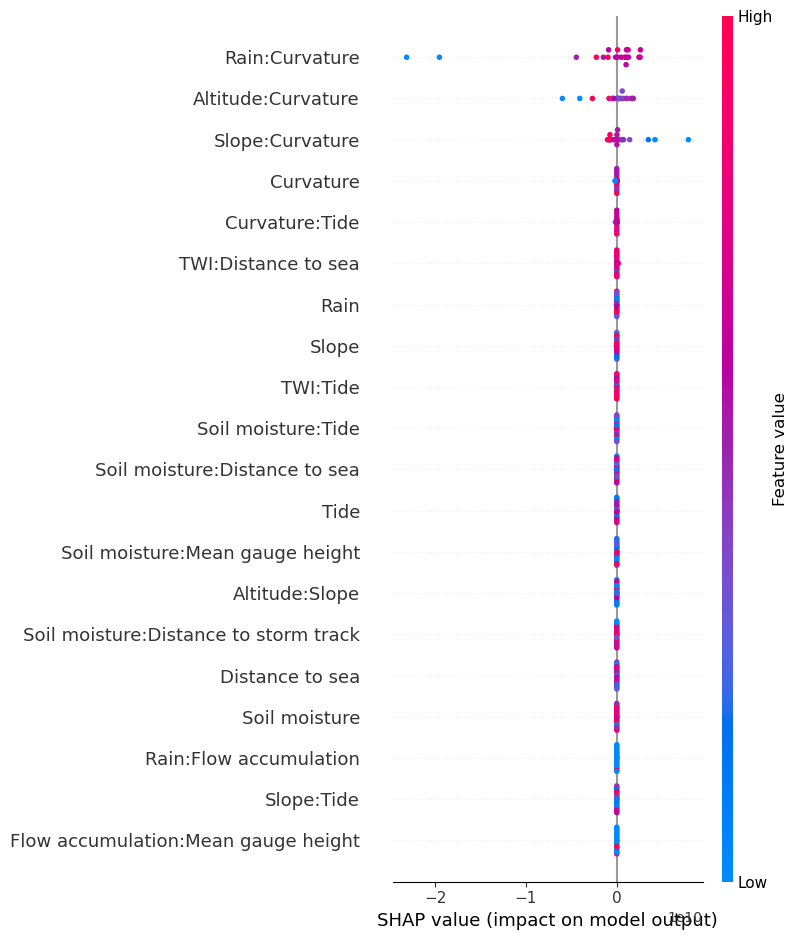

In [46]:
# Generate the SHAP summary plot
shap.summary_plot(shap_values, Xtest, feature_names=features2)

### Saving the model

In [7]:
# Specify the path and filename for the model
model_path = 'Scenario1.h5'

# Use the .save() method to save your model
model.save(model_path)

print(f"Model saved to {model_path}")

Model saved to Scenario1.h5


### Scatter plot

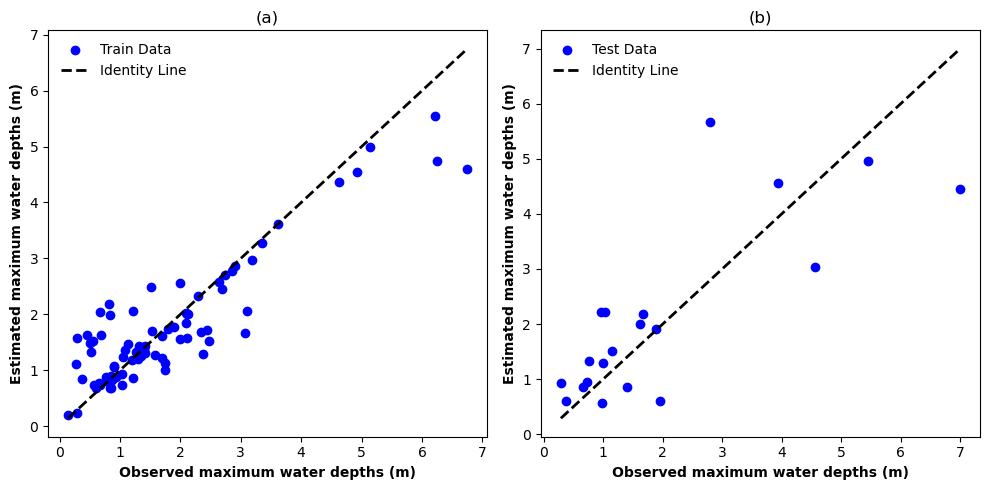

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Scatter plot for simulated vs observed max flood depths (Train Data)
axes[0].scatter(Ytrain, Ytrain_pred, color='blue', label='Train Data')
axes[0].plot([Ytrain.min(), Ytrain.max()], [Ytrain.min(), Ytrain.max()], 'k--', lw=2, label='Identity Line')
axes[0].set_xlabel('Observed maximum water depths (m)', fontweight='bold')
axes[0].set_ylabel('Estimated maximum water depths (m)', fontweight='bold')
axes[0].set_title('(a)')
axes[0].legend(frameon=False)  # No legend box

# Scatter plot for simulated vs observed max flood depths (Test Data)
axes[1].scatter(Ytest, Ytest_pred, color='blue', label='Test Data')
axes[1].plot([Ytest.min(), Ytest.max()], [Ytest.min(), Ytest.max()], 'k--', lw=2, label='Identity Line')
axes[1].set_xlabel('Observed maximum water depths (m)', fontweight='bold')
axes[1].set_ylabel('Estimated maximum water depths (m)', fontweight='bold')
axes[1].set_title('(b)')
axes[1].legend(frameon=False)  # No legend box

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

### Evaluating stream gauges, HWMs, and stream gagues+HWMs

In [41]:
# Conversion factor from some unit to meters, assuming 'Flood' is initially in some other units
y_stream = df['Flood'] * 0.3048 

# Ensure 'features' contains the correct column names you want to use for the model
x_stream = df[features].copy()

# Scale the data
x_stream_scaled = scaler.fit_transform(x_stream)

In [ ]:
df_HWM = df_all[df_all['Type'] == 'HWMs']
y_HWM = df_HWM['Flood'] * 0.3048 


# Ensure you are working on a copy of the DataFrame
df_HWM = df_HWM.copy()

# Loop through the interaction terms and create each interaction column using .loc
for term1, term2 in interaction_terms:
    column_name = f'{term1}:{term2}'
    df_HWM.loc[:, column_name] = df_HWM[term1] * df_HWM[term2]

x_HWM = df_HWM[features].copy()
x_HWM_scaled = scaler.fit_transform(x_HWM)

In [43]:
from sklearn.metrics import r2_score, mean_absolute_error, median_absolute_error, mean_squared_error

def evaluate_model(predictions, actuals, model_name):
    # Flatten predictions if necessary
    predictions = predictions.flatten()
    
    # Calculate metrics
    r_squared = np.round(r2_score(actuals, predictions), 2)
    mae = mean_absolute_error(actuals, predictions)
    mdae = median_absolute_error(actuals, predictions)
    nrmse = np.sqrt(mean_squared_error(actuals, predictions)) * 100 / np.mean(actuals)
    bias = np.mean(predictions - actuals)
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    
    # Prepare DataFrame
    errors_df = pd.DataFrame({
        "Metric": ["R-squared", "MAE", "Median Absolute Error", "NRMSE", "BIAS", "RMSE"],
        "Value": [r_squared, mae, mdae, nrmse, bias, rmse]
    })
    
    # Print the DataFrame to check
    print(f"Errors for {model_name}:")
    print(errors_df)

    # Save to CSV
    errors_df.to_csv(f"errors_{model_name}.csv", index=False)

    return errors_df


In [100]:
# Evaluate the model for stream gauges, HWMs, and both streamgauges and HWMs
x_combined = np.concatenate((x_HWM_scaled, x_stream_scaled))
y_combined = np.concatenate((y_HWM, y_stream))
y_combined_pred = model.predict(x_combined)
errors_df_combined = evaluate_model(y_combined_pred, y_combined, "Overall_S1")

y_stream_pred = model.predict(x_stream_scaled)
errors_df_stream = evaluate_model(y_stream_pred, y_stream, "Stream_S1")

y_HWM_pred = model.predict(x_HWM_scaled)
errors_df_HWM = evaluate_model(y_HWM_pred, y_HWM, "HWMs_S1")

12/12 [==============================] - 0s 1ms/step
Errors for Overall_S1:
                  Metric       Value
0              R-squared   -0.300000
1                    MAE    0.950084
2  Median Absolute Error    0.800733
3                  NRMSE  137.295958
4                   BIAS    0.735691
5                   RMSE    1.208317
4/4 [==============================] - 0s 2ms/step
Errors for Stream_S1:
                  Metric      Value
0              R-squared   0.760000
1                    MAE   0.484226
2  Median Absolute Error   0.260330
3                  NRMSE  39.691377
4                   BIAS   0.000386
5                   RMSE   0.728130
9/9 [==============================] - 0s 1ms/step
Errors for HWMs_S1:
                  Metric       Value
0              R-squared   -6.900000
1                    MAE    1.128844
2  Median Absolute Error    1.044802
3                  NRMSE  262.308985
4                   BIAS    1.017842
5                   RMSE    1.347900


## Transferability

### Ian

In [9]:
from sklearn.metrics import r2_score, mean_absolute_error, median_absolute_error, mean_squared_error


# Read the CSV file into a pandas DataFrame
df_Ian = pd.read_csv('Ian.csv', header=0)


# Ensure you are working on a copy of the DataFrame
df_Ian = df_Ian.copy()

# Loop through the interaction terms and create each interaction column using .loc
for term1, term2 in interaction_terms:
    column_name = f'{term1}:{term2}'
    df_Ian.loc[:, column_name] = df_Ian[term1] * df_Ian[term2]



x_Ian = df_Ian[features].copy()

y_Ian = df_Ian['Flood']* 0.3048  

# Scale the data
x_Ian_scaled = scaler.fit_transform(x_Ian)


# Evaluate the model on the test set
y_Ian_pred = model.predict(x_Ian_scaled)


print("R-squared for Ian:{}".format(np.round(r2_score(y_Ian, y_Ian_pred), 2)))
print("MAE for Ian: {:.2f}".format(mean_absolute_error(y_Ian, y_Ian_pred)))
print("Median Absolute Error for Ian: {:.2f}".format(median_absolute_error(y_Ian, y_Ian_pred)))
print("Root mean square error for Ian: {}". format(np.round(np.sqrt(mean_squared_error(y_Ian, y_Ian_pred)), 2)))
print("BIAS for Ian: {:.2f}".format(np.mean(y_Ian_pred - y_Ian.values.flatten())))
print("Normalized Root Mean Square Error for Ian: {:.2f}".format(np.sqrt(mean_squared_error( y_Ian, y_Ian_pred))*100 / ( np.mean(y_Ian))))
#print("Ratio of Prediction over Observation for Ian: {:.2f}".format(np.mean(y_Ian_pred*100 / y_Ian.values.flatten())))


# pbias = 100 * np.sum(y_Ian_pred - y_Ian.values.flatten()) / np.sum(y_Ian.values.flatten())
# print("PBIAS for Ian: {:.2f}%".format(pbias))

R-squared for Ian:-2.35
MAE for Ian: 0.98
Median Absolute Error for Ian: 0.87
Root mean square error for Ian: 1.22
BIAS for Ian: 0.71
Normalized Root Mean Square Error for Ian: 141.28


### Michael

In [10]:
# Read the CSV file into a pandas DataFrame
df_Michael = pd.read_csv('Micheal.csv', header=0)


# Ensure you are working on a copy of the DataFrame
df_Michael = df_Michael.copy()

# Loop through the interaction terms and create each interaction column using .loc
for term1, term2 in interaction_terms:
    column_name = f'{term1}:{term2}'
    df_Michael.loc[:, column_name] = df_Michael[term1] * df_Michael[term2]


x_Michael = df_Michael[features].copy()

y_Michael = df_Michael['Flood']* 0.3048 

# Scale the data
x_Michael_scaled = scaler.fit_transform(x_Michael)


# Evaluate the model on the test set
y_Michael_pred = model.predict(x_Michael_scaled).flatten()

# Calculate R-squared
r_squared = r2_score(y_Michael, y_Michael_pred)


print("R-squared for Michael:{}".format(np.round(r_squared, 2)))
print("MAE for Michael: {:.2f}".format(mean_absolute_error(y_Michael, y_Michael_pred)))
print("Median Absolute Error for Michael: {:.2f}".format(median_absolute_error(y_Michael, y_Michael_pred)))
print("Root mean square error for Michael: {}". format(np.round(np.sqrt(mean_squared_error(y_Michael, y_Michael_pred)), 2)))
print("BIAS for Michael: {:.2f}".format(np.mean(y_Michael_pred - y_Michael.values.flatten())))
print("Normalized Root Mean Square Error for Michael: {:.2f}".format(np.sqrt(mean_squared_error( y_Michael, y_Michael_pred))*100 / ( np.mean(y_Michael))))

R-squared for Michael:-8.49
MAE for Michael: 1.23
Median Absolute Error for Michael: 0.72
Root mean square error for Michael: 2.27
BIAS for Michael: 0.88
Normalized Root Mean Square Error for Michael: 265.22
